# Movie Reviews Sentiment Analysis

In this project, we’ll build binary classification that puts movie reviews texts into one of two categories — negative or positive sentiment.

[Source Link](https://thecleverprogrammer.com/2020/05/25/movie-reviews-sentiment-analysis-binary-classification-with-machine-learning/#google_vignette)

## Impotring the libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

## Unzipping the dataset

In [2]:
from pathlib import Path
from zipfile import ZipFile

file_path = "./data/IMDB-Dataset.csv"
zip_file_path = "./data/IMDB-Dataset.zip"

# Check if the file already exists
if not Path(file_path).exists():
    print(f"The file '{file_path}' does not exist. Unzipping...")

    # Extract the contents of the zip file to the destination directory
    with ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall("./data/")

    print("Unzip completed successfully.")
else:
    print(f"The file '{file_path}' already exists, skipping unzip.")

The file './data/IMDB-Dataset.csv' already exists, skipping unzip.


## Loading the dateset

In [3]:
df = pd.read_csv("data/IMDB-Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


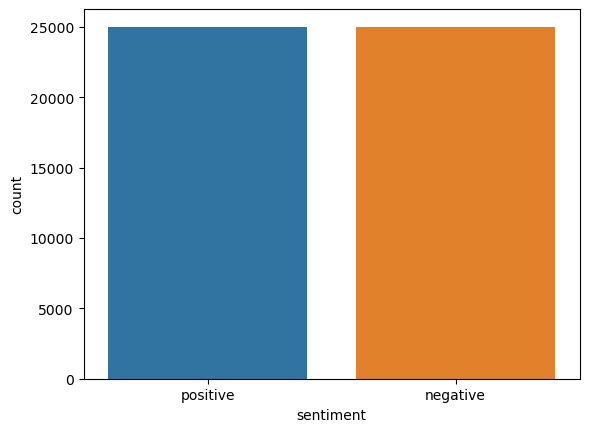

In [5]:
sns.countplot(df, x="sentiment");

## Cleaning the reviews

- Remove HTML tags
- Remove special characters
- Convert everything to lowercase
- Remove stopwords
- Stemming

In [6]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

In [7]:
stop_words = set(stopwords.words("english"))
ss = SnowballStemmer("english")

def clean(text: str) -> str:
    # Converting all words to lower case
    text = text.lower()

    # Removing html tags and special characters
    text = re.sub(r"<.*?>", " ", text)

    # Removing stop word as stemming
    words = word_tokenize(text)
    text = " ".join(ss.stem(w) for w in words if w not in stop_words)

    # Removing special characters
    text = re.sub(r"[^a-z0-9 ]", " ", text)

    # Removing extra spaces
    text = re.sub(r"[ ]+", " ", text)

    return text

In [8]:
df["review"] = df["review"].apply(clean)
df["review"][1]

'wonder littl product film techniqu unassuming old time bbc fashion give comfort sometim discomfort sens realism entir piec actor extrem well chosen michael sheen got polari voic pat truli see seamless edit guid refer william diari entri well worth watch terrif written perform piec master product one great master s comedi life realism realli come home littl thing fantasi guard rather use tradit dream techniqu remain solid disappear play knowledg sens particular scene concern orton halliwel set particular flat halliwel s mural decor everi surfac terribl well done '

## Creating the model

### Creating bag of words

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

reviews = df.iloc[:, 0].values
y = df["sentiment"].values

cv = CountVectorizer(max_features=1000)
X = cv.fit_transform(reviews).toarray()

print(f"X {X.shape}")
print(f"y {y.shape}")

X (50000, 1000)
y (50000,)


### Train test split

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state=9)

print("Train shapes : X = {}, y = {}".format(X_train.shape,y_train.shape))
print("Test  shapes : X = {}, y = {}".format(X_test.shape,y_test.shape))

Train shapes : X = (40000, 1000), y = (40000,)
Test  shapes : X = (10000, 1000), y = (10000,)


### Defining the models and Training them

In [18]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB

gnb = GaussianNB()
mnb = MultinomialNB(alpha=1.0, fit_prior=True)
bnb = BernoulliNB(alpha=1.0, fit_prior=True)

gnb.fit(X_train, y_train)
mnb.fit(X_train, y_train)
bnb.fit(X_train, y_train)

BernoulliNB()

### Prediction and accuracy metrics to choose best model

In [19]:
from sklearn.metrics import accuracy_score

y_pred_gnb = gnb.predict(X_test)
y_pred_mnb = mnb.predict(X_test)
y_pred_bnb = bnb.predict(X_test)

print(f"Gaussian    = {(accuracy_score(y_test, y_pred_gnb)):0.3f}")
print(f"Multinomial = {(accuracy_score(y_test, y_pred_mnb)):0.3f}")
print(f"Bernoulli   = {(accuracy_score(y_test, y_pred_bnb)):0.3f}")

Gaussian    = 0.781
Multinomial = 0.831
Bernoulli   = 0.839


## Evaluating the best model (bnb)


Classification Report:
              precision    recall  f1-score   support

    negative       0.85      0.82      0.84      5023
    positive       0.83      0.86      0.84      4977

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



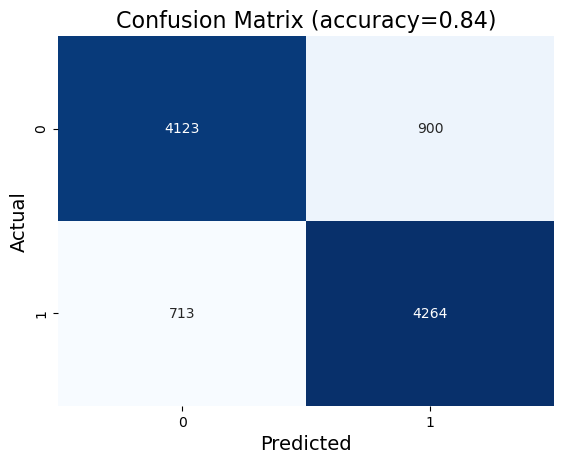

In [20]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_pred_bnb)
report = classification_report(y_test, y_pred_bnb)
accuracy = accuracy_score(y_test, y_pred_bnb)
print(f"\nClassification Report:\n{report}")
ax = sns.heatmap(cm, annot=True, cmap="Blues", cbar=False, fmt="d")
ax.set_xlabel("Predicted", fontsize=14)
ax.set_ylabel("Actual", fontsize=14)
ax.set_title(f"Confusion Matrix (accuracy={accuracy:.2f})", fontsize=16);

## Live prediction

In [46]:
def live_prediction(review):
    review = clean(review)
    review = np.array([review])
    review = cv.transform(review)
    prediction = bnb.predict(review)
    if prediction[0] == "positive":
        print("This tweet has 'Positive Sentiment'")
    else:
        print("This tweet has 'Negative Sentiment'")
    print("-" * 50)

In [51]:
example_negetive_review = """Terrible. Complete trash. Brainless tripe. Insulting to anyone who isn't an 8 year old fan boy.
Im actually pretty disgusted that this movie is making the money it is - what does it say about the people who brainlessly
hand over the hard earned cash to be 'entertained' in this fashion and then come here to leave a positive 8.8 review??
Oh yes, they are morons. Its the only sensible conclusion to draw.
How anyone can rate this movie amongst the pantheon of great titles is beyond me.
So trying to find something constructive to say about this title is hard...I enjoyed Iron Man?
Tony Stark is an inspirational character in his own movies but here he is a pale shadow of that...
About the only 'hook' this movie had into me was wondering when and if Iron Man would knock Captain America out...
Oh how I wished he had :( What were these other characters anyways? Useless, bickering idiots who really couldn't
organise happy times in a brewery. The film was a chaotic mish mash of action elements and failed 'set pieces'...
I found the villain to be quite amusing.
And now I give up. This movie is not robbing any more of my time
but I felt I ought to contribute to restoring the obvious fake rating and reviews this movie has been getting on IMDb."""
live_prediction(example_negetive_review)


example_positive_review = """This short film that inspired the soon-to-be full length feature - Spatula Madness - is a hilarious
piece that contends against similar cartoons yielding multiple writers.
The short film stars Edward the Spatula who after being fired from his job, joins in the fight against the evil spoons.
This premise allows for some funny content near the beginning,
but is barely present for the remainder of the feature.
This film's 15-minute running time is absorbed by some odd-ball comedy and a small musical number.
Unfortunately not much else lies below it. The plot that is set up doesn't really have time to show.
But it's surely follows it plot better than many high-budget Hollywood films.
This film is worth watching at least a few times. Take it for what it is, and don't expect a deep story."""
live_prediction(example_positive_review)

This tweet has 'Negative Sentiment'
--------------------------------------------------
This tweet has 'Positive Sentiment'
--------------------------------------------------
